In [1]:
from ase.io import read as aseread
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def vis_chains(vis_config):
    '''Takes an ASE atoms object or list thereof and creates a customised ngl viewer 
       with appropriate settings for our bulk alkane chain models'''
    Nchains=250
    Nbeads = 4
    met = 0.35
    rad = 1.0
    
    colours = ['#FF1111','#FFAAAA', '#DDDDDD', '#1111FF']#, '#AAAAFF']
    ncols = len(colours)
    
    sel=list()
    for icol in range(ncols):
        sel.append(list())
    
    # Create lists for each colour
    for ichain in range(0, Nchains):
        icol = ichain%ncols
        for ibead in range(Nbeads):
            iatom = ichain*Nbeads + ibead
            sel[icol].append(iatom)
            
    v = view(vis_config, viewer='ngl')                   
    v.view.clear_representations()
    #v.view.add_representation('unitcell', color='#000000')
    
    for icol in range(ncols):
        v.view.add_representation('ball+stick', selection=sel[icol], color=colours[icol], radius=rad, metalness=met)

    return v

In [3]:
def molecular_axis(config, Nbeads, ichain):
    
    """
    
    Finds the molecular axis of chain number ichain as the eigenvalue associated with
    the smallest eigenvalue of the inertia tensor. 
    
    """    
    
    # Find the positions of all beads and the centre of mass relative to the first bead.
    # For our purposes the centre of mass is the centroid.
    rcom = np.zeros(3)
    
    relpos = np.zeros((Nbeads, 3))
    
    for j in range(Nbeads):
    
        relpos[j] = config.get_distance(ichain*Nbeads, ichain*Nbeads+j, mic=True, vector=True)
        rcom = rcom + relpos[j]
    
    rcom = rcom/Nbeads # Centre of mass
    
    # Calculate inertia tensor
    Itensor = np.zeros((3,3)) 
    
    for j in range(Nbeads):
        
        relpos[j] = relpos[j] - rcom # Now relative to centre of mass
        Itensor = Itensor + np.dot(relpos[j],relpos[j])*np.identity(3) - np.outer(relpos[j], relpos[j])
    
    # Diagonalise and find eigenvector for smallest eigenvalue
    eigenvals, eigenvects = np.linalg.eig(Itensor)
    mineig = np.amin(eigenvals)
    k = np.where(eigenvals == mineig)
    
    direction = eigenvects[k]/np.linalg.norm(eigenvects[k])
    
    return direction

In [5]:
def alt_nematic_order_param(configs,Nbeads,Nchains):
    
    """
    
    Plots the nematic order parameter over time for an array of Atoms Objects or a trajectory.
    
    configs: Array of Atoms Objects/Trajectory for the atoms objects which needs to be calculated
    Nbeads: Number of beads in the chain which is being calculated
    Nchains: The number of chains present in the system which is being calculated
    
    """

    order_param_array=[]
    Nconfigs = len(configs) 


    for img in configs:
        
        Q_sum = np.zeros((3,3)) # Initialise Q_sum
        
        for i in range(Nchains):
            
            # Calculate the vector from the beginning chain to the end chain
            # -- Note that I'm letting ASE just do all the work for me here!

            a0 = i*Nbeads      # index of zeroth bead on chain i
            a1 = i*Nbeads + 3  # index of 4th bead on chain i 

            # Find end-to-end vector
            chainvector = img.get_distance(a0, a1, mic=True, vector=True)
            
            # Alternatively use molecular direction from inertia tensor
#             chainvector = molecular_axis(img, Nbeads, i)
            
            # Normalise chainvector
            chainvector = chainvector/np.linalg.norm(chainvector)

            # Accumulate Q_sum
            Q_sum = Q_sum + 1.5 * np.outer(chainvector, chainvector) - 0.5 * np.identity(3)
            
           
        # Find the average Q
        Qav = Q_sum/Nchains
        # Diagonalise this
        eigenvals, eigenvects = np.linalg.eig(Qav)
        
        # The maximum positive eigenvalue is the P2 order parameter
        P2 = np.amax(eigenvals)
        
        order_param_array.append(P2)
        
        # If we wanted the director then this is the corresponding eigenvector
        #k = np.where(eigenvals == P2)
        #director = eigenvects[k]
        
        
    
    return order_param_array

In [6]:

from ase import io



In [7]:
!ls PhaseI/PvV_results_1/

PvV_solid.txt  solidP16.0  solidP24.0  solidP32.0  solidP40.0  solidP48.0
solidP10.0     solidP18.0  solidP26.0  solidP34.0  solidP42.0  solidP50.0
solidP12.0     solidP20.0  solidP28.0  solidP36.0  solidP44.0
solidP14.0     solidP22.0  solidP30.0  solidP38.0  solidP46.0


In [8]:
pwd ="Fluid/PvV_results_1"
cond ="fluidP46.0"
amorph_config = io.Trajectory(f"{pwd}/{cond}/configs.traj", 'r')
phase1_config = io.Trajectory(f"PhaseI/PvV_results_1/solidP46.0/configs.traj", 'r')
phase3_config = io.Trajectory(f"PhaseIII/PvV_results_1/solidP46.0/configs.traj", 'r')

In [9]:
v = vis_chains(phase1_config)
#v = view(config, viewer='nglview')
v

In [11]:
amorph_order_param=alt_nematic_order_param(amorph_config,Nbeads,Nchains)
phase1_order_param=alt_nematic_order_param(phase1_config,Nbeads,Nchains)
phase3_order_param=alt_nematic_order_param(phase3_config,Nbeads,Nchains)

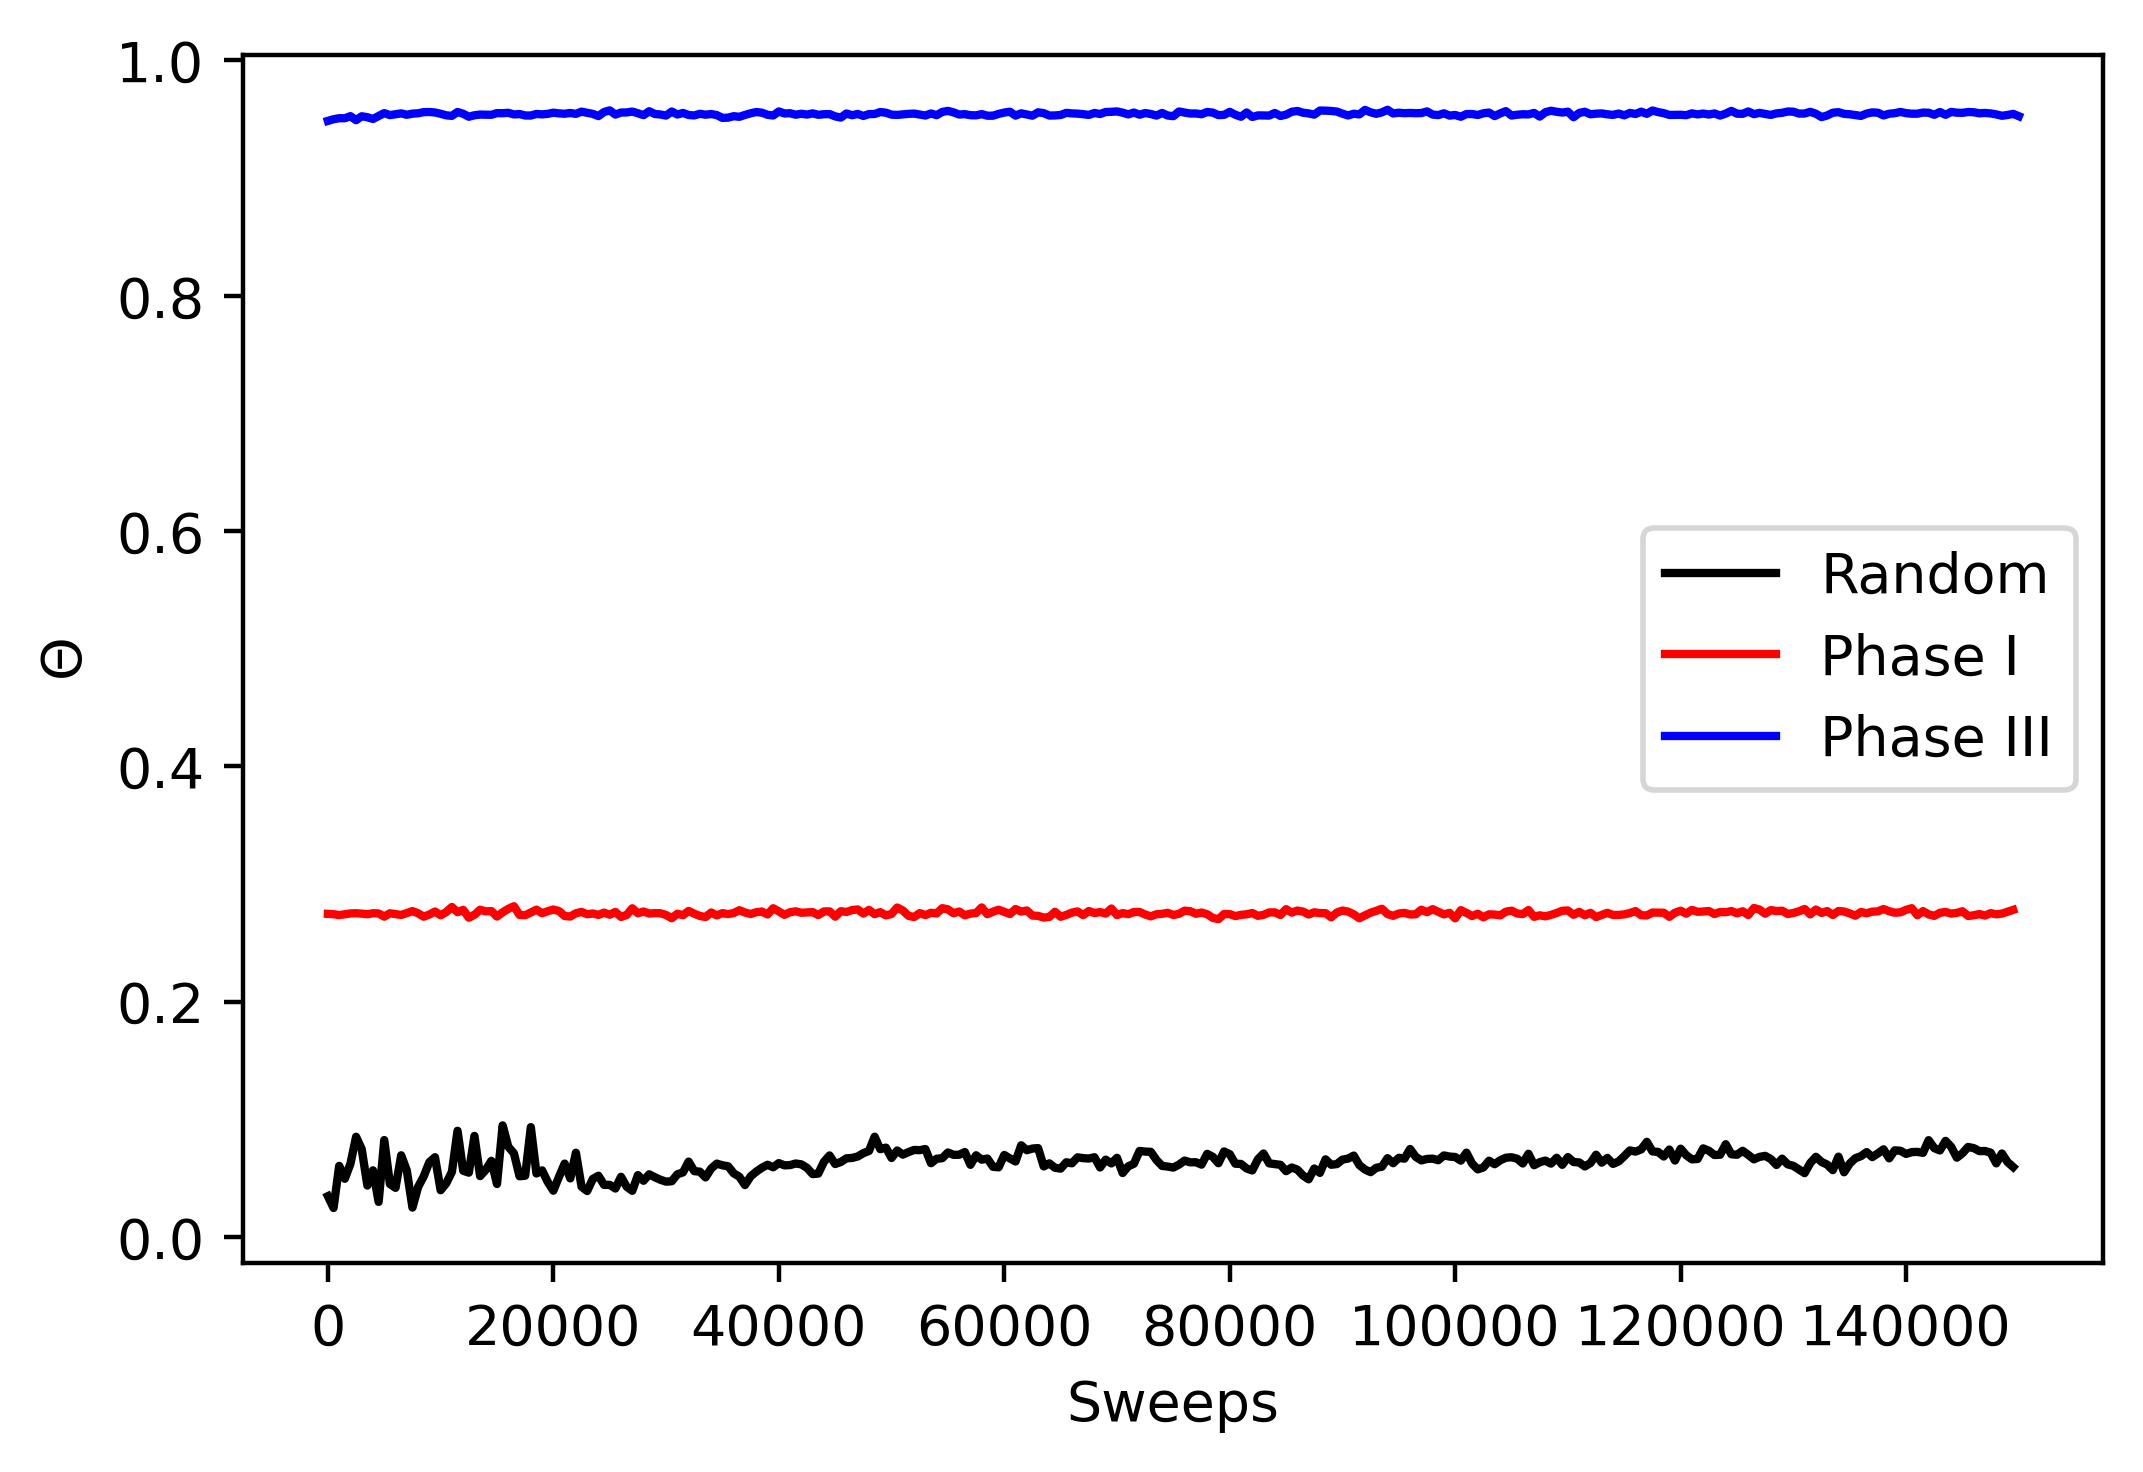

In [13]:
plt.figure(figsize=(6,4),dpi=400)
plt.plot(np.arange(300)*500,amorph_order_param, label='Random' , c = 'k')
plt.plot(np.arange(300)*500,phase1_order_param, label='Phase I' , c = 'r')
plt.plot(np.arange(301)*500,phase3_order_param, label='Phase III' , c = 'b')
plt.ylabel(r'$\Theta$')
plt.xlabel("Sweeps")

plt.legend()

plt.show()

Fluid/PvV_results_1


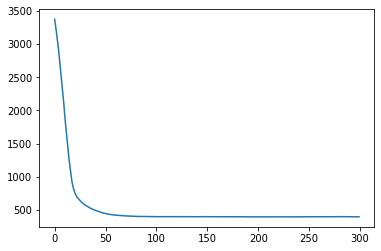

In [14]:
import matplotlib.pyplot as plt
print(pwd)
vol = []
for line in open(f"{pwd}/{cond}/all_volumes.txt", 'r'):
    vol.append(float(line))
    #print(type(line))
plt.plot(vol[::50])
plt.show()

In [16]:
!ls PvV_results_10

fluidP10  fluidP20  fluidP30  fluidP40	fluidP50  PvV_fluid.txt
fluidP15  fluidP25  fluidP35  fluidP45	fluidP55


In [17]:
#close(f"{pwd}/all_volumes.txt", 'r')

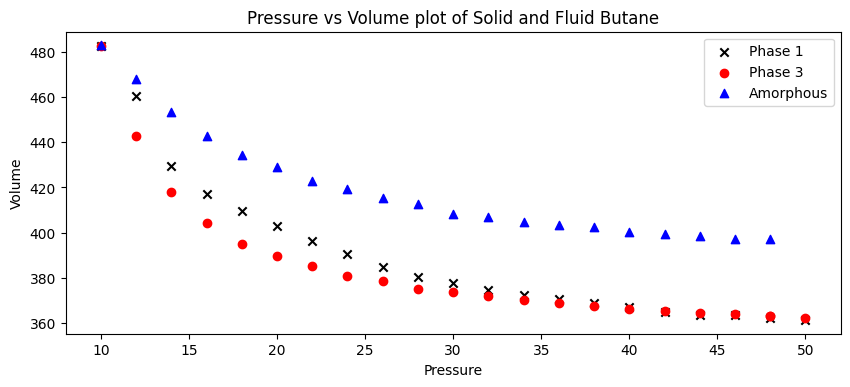

In [18]:
phase1p=[]
phase1v=[]
phase3p=[]
phase3v=[]
serr=[]
fluidp=[]
fluidv=[]
ferr=[]

for line in open("PhaseI/PvV_results_1/PvV_solid.txt", 'r'):
    #print(line)
    l = line.split(",")   
    phase1p.append(float(l[0]))
    phase1v.append(float(l[1]))
#     serr.append(float(l[2]))
    #print(type(line))
    
for line in open(f"Fluid/PvV_results_1/PvV_fluid.txt", 'r'):
    #print(line)
    l = line.split(",")    
    fluidp.append(float(l[0]))
    fluidv.append(float(l[1]))
    ferr.append(float(l[2]))
    
for line in open("PhaseIII/PvV_results_1/PvV_solid.txt", 'r'):
    #print(line)
    l = line.split(",")    
    phase3p.append(float(l[0]))
    phase3v.append(float(l[1]))
#     serr.append(float(l[2]))

plt.figure(figsize=(10,4), dpi=100)
plt.title("Pressure vs Volume plot of Solid and Fluid Butane")
plt.scatter(phase1p[:],phase1v[:], marker='x',c='k', label="Phase 1")
plt.scatter(phase3p[:],phase3v[:], marker='o',c='r', label="Phase 3")
plt.scatter(fluidp[:],fluidv[:], marker='^', c='b', label="Amorphous")

plt.legend()


#plt.errorbar(phase1p[5:],phase1v[5:],yerr=serr[5:], fmt='kx', label = 'Solid')
#plt.errorbar(fluidp[5:],fluidv[5:],yerr=ferr[5:], fmt='rx', label = 'Fluid')
plt.xlabel("Pressure")
plt.ylabel("Volume")
plt.show()

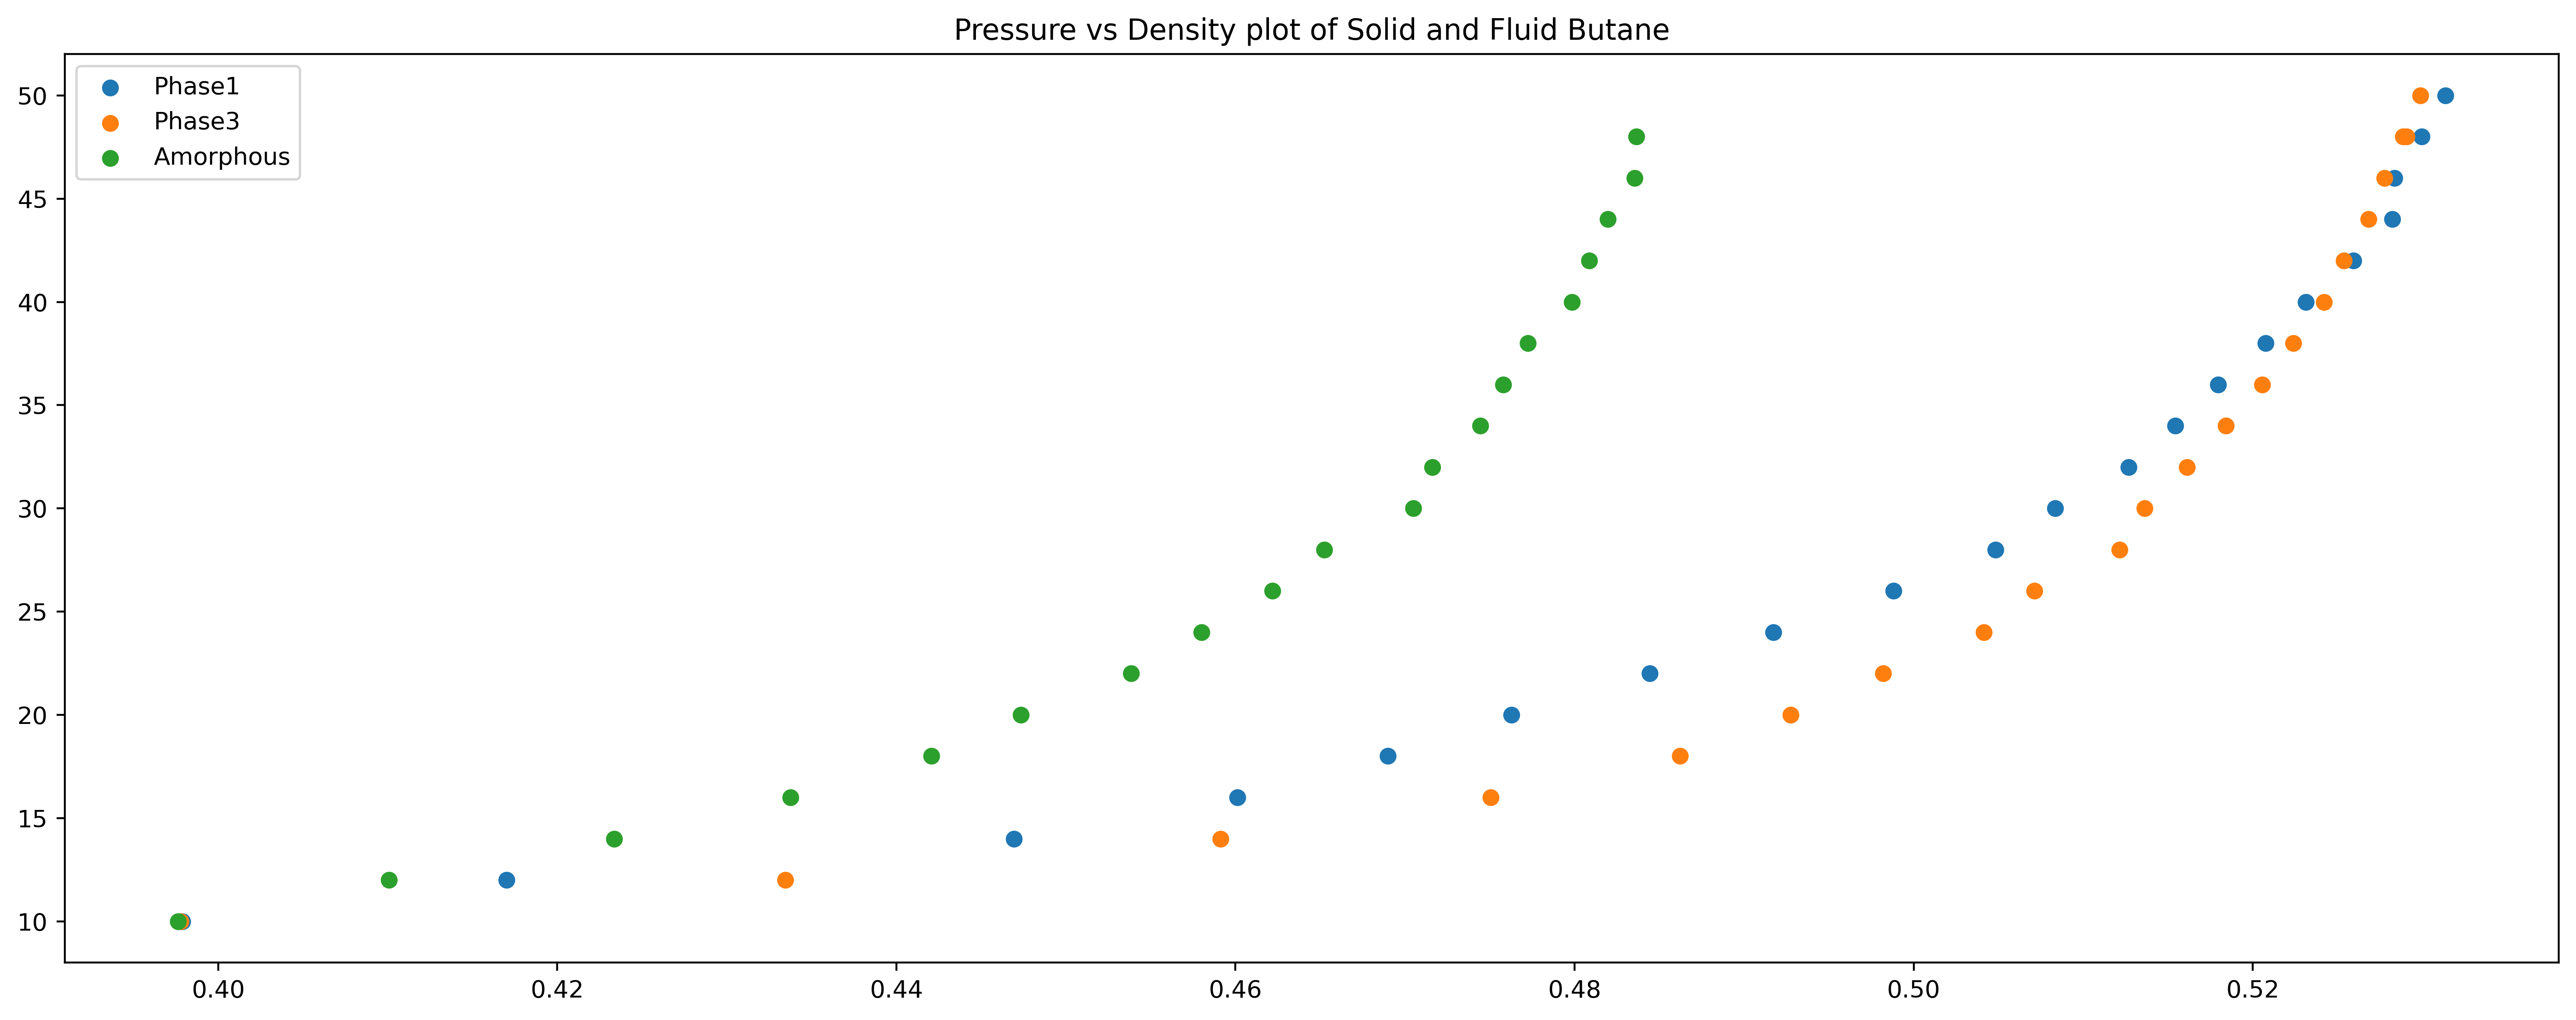

In [19]:
phase1p = np.array(phase1p)
phase3p = np.array(phase3p)
fluidp = np.array(fluidp)

phase1d = 192/np.array(phase1v)
phase3d = 192/np.array(phase3v)
fluidd = 192/np.array(fluidv)

plt.figure(figsize=(15,6), dpi=400)
plt.title("Pressure vs Density plot of Solid and Fluid Butane")
plt.scatter(phase1d,phase1p, label = 'Phase1')
plt.scatter(phase3d,phase3p, label = 'Phase3')
plt.scatter(fluidd,fluidp, label = 'Amorphous')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
df1=pd.read_csv('DigitisedMalinoskiSigma.csv', sep=',',skiprows=5, usecols=[0,1])
df2=pd.read_csv('DigitisedYethirajSigma.csv', sep=',',skiprows=5, usecols=[0,1])


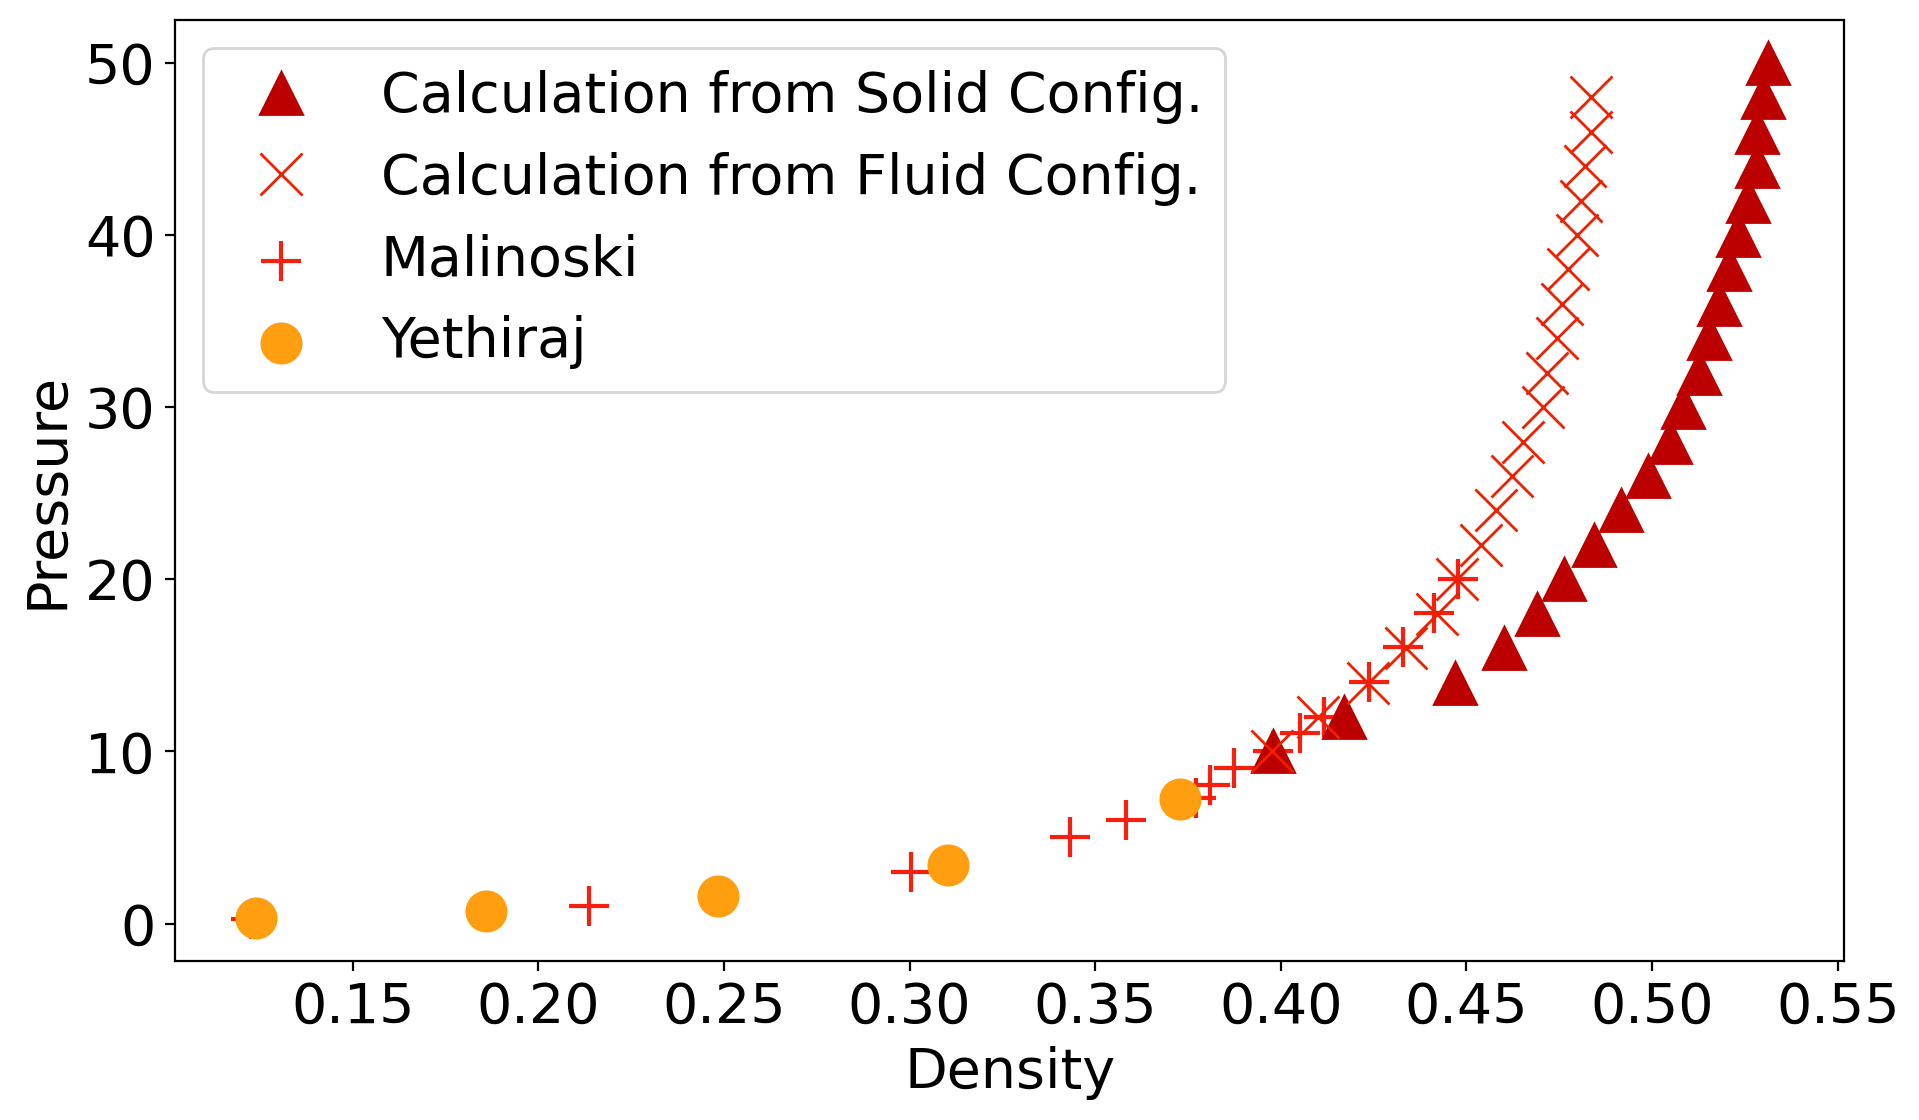

In [29]:
fig,ax=plt.subplots(figsize=(10,6), dpi = 200)
plt.rcParams.update({'font.size': 20})

df1.plot("Density","Pressure", kind = 'scatter', ax=ax, c='#FA1E0E', s=200, label = "Malinoski", marker ='+')
df2.plot("Density","Pressure", kind = 'scatter', ax=ax, c='#FF9E0F', s=200, label = "Yethiraj", marker = 'o')
ax.plot(phase1d,phase1p, ms=15, label = 'Calculation from Solid Config.', c='#BC0000', marker  = '^', lw=0)
ax.plot(fluidd,fluidp, ms=15, label = 'Calculation from Fluid Config.', c='#ED2000', marker  = 'x', lw=0)
plt.legend()
plt.tight_layout()
fig.show()